In [9]:
from __future__ import division
import numpy as np
import random as rnd

gam = 1.5
dt = 0.01
nsteps = 20000
nsteps_relax = 0
nrun = 400
window_size = 10
thres = 0.75

def integrate_motion(nr, n, dt, gamma):

    sqrt_dt = np.sqrt(dt)
    rnd.seed()

    # estado inicial  0=x ,1=y
    v = np.array([rnd.gauss(0,1)/np.sqrt(2*gamma),
                  rnd.gauss(0,1)/np.sqrt(2*gamma)])
    u = np.array([rnd.gauss(0,1)/np.sqrt(2*gamma),
                  rnd.gauss(0,1)/np.sqrt(2*gamma)])

    def f_u(v): return v
    def f_v(v,u): return -gamma*v - u
        
# RELAJACIÓN
    for _ in range(nr):
        for k in (0,1):
            vk = v[k]
            uk = u[k]

            k1u = dt * f_u(vk)
            k1v = dt * f_v(vk, uk)

            k2u = dt * f_u(vk + 0.5*k1v)
            k2v = dt * f_v(vk + 0.5*k1v, uk + 0.5*k1u)

            k3u = dt * f_u(vk + 0.5*k2v)
            k3v = dt * f_v(vk + 0.5*k2v, uk + 0.5*k2u)

            k4u = dt * f_u(vk + k3v)
            k4v = dt * f_v(vk + k3v, uk + k3u)

            u[k] += (k1u + 2*k2u + 2*k3u + k4u)/6
            v[k] += (k1v + 2*k2v + 2*k3v + k4v)/6 + sqrt_dt*rnd.gauss(0,1)


# ESTADO PERMANENTE

    vx_arr = np.zeros(n)
    vy_arr = np.zeros(n)

    for i in range(n):
        for k in (0,1):
            vk = v[k]
            uk = u[k]

            k1u = dt * f_u(vk)
            k1v = dt * f_v(vk, uk)

            k2u = dt * f_u(vk + 0.5*k1v)
            k2v = dt * f_v(vk + 0.5*k1v, uk + 0.5*k1u)

            k3u = dt * f_u(vk + 0.5*k2v)
            k3v = dt * f_v(vk + 0.5*k2v, uk + 0.5*k2u)

            k4u = dt * f_u(vk + k3v)
            k4v = dt * f_v(vk + k3v, uk + k3u)

            u[k] += (k1u + 2*k2u + 2*k3u + k4u)/6
            v[k] += (k1v + 2*k2v + 2*k3v + k4v)/6 + sqrt_dt*rnd.gauss(0,1)

        vx_arr[i] = v[0]
        vy_arr[i] = v[1]

    vnorm2_arr = vx_arr**2 + vy_arr**2
    vnorm_arr = np.sqrt(vnorm2_arr)

    return (
        vx_arr,
        vy_arr,
        vnorm2_arr,
        vx_arr / vnorm_arr,
        vy_arr / vnorm_arr
    )


def compute_theta(dt, vx, vy):
    
    theta_corr = np.zeros(len(vx))
    theta_corr[0] = np.arctan2(vy[0], vx[0])

    spin = []
    t_spin = []
    nber_loop = 0

    for i in range(1, len(vx)):
        theta_raw = np.arctan2(vy[i], vx[i])

        base = nber_loop * 2*np.pi
        trials = np.array([
            theta_raw + base,
            theta_raw + base + 2*np.pi,
            theta_raw + base - 2*np.pi
        ])

        k = np.argmin(np.abs(trials - theta_corr[i-1]))
        theta_corr[i] = trials[k]

        if k == 1: nber_loop += 1
        elif k == 2: nber_loop -= 1

        eps = 1 if theta_corr[i] > theta_corr[i-1] else -1

        if i < 2:
            spin.append(eps)
            t_spin.append(0)
        else:
            if eps * spin[-1] < 0:
                spin.append(eps)
                t_spin.append(i-1)

    return theta_corr, spin, t_spin

# INTEGRACIÓN 


vx_arr_all = np.zeros((nsteps, nrun))
vy_arr_all = np.zeros((nsteps, nrun))

# OPTIMIZADO: FFT precomputada
fft = np.fft.fft

spectrum_all = np.zeros((nsteps, nrun))
spectrum_ori_all = np.zeros((nsteps, nrun))
spectrum_norm2_all = np.zeros((nsteps, nrun))

for j in range(nrun):
    vx_arr, vy_arr, vnorm2_arr, vorix_arr, voriy_arr = integrate_motion(
        nsteps_relax, nsteps, dt, gam
    )

    vx_arr_all[:,j] = vx_arr
    vy_arr_all[:,j] = vy_arr

    fv = fft(vx_arr)
    fv2 = fft(vy_arr)
    spectrum_all[:,j] = np.abs(fv)**2 + np.abs(fv2)**2

    fo = fft(vorix_arr)
    fo2 = fft(voriy_arr)
    spectrum_ori_all[:,j] = np.abs(fo)**2 + np.abs(fo2)**2

    fn = fft(vnorm2_arr)
    spectrum_norm2_all[:,j] = np.abs(fn)**2

# JACKKNIFE 

# OPTIMIZADO: Promedios vectorizados
spectrum_ori = spectrum_ori_all.mean(axis=1)
spectrum_norm2 = spectrum_norm2_all.mean(axis=1)
spectrum = spectrum_all.mean(axis=1)

# OPTIMIZADO: Jackknife mucho más rápido con broadcasting
def jackknife_err(array, mean):
    N = array.shape[1]
    jk = (mean[:,None] - (array.sum(axis=1)[:,None] - array) / (N-1))
    return np.sqrt((jk**2).sum(axis=1))

u_spectrum_ori = jackknife_err(spectrum_ori_all, spectrum_ori)
u_spectrum_norm2 = jackknife_err(spectrum_norm2_all, spectrum_norm2)
u_spectrum = jackknife_err(spectrum_all, spectrum)

# normalización
spectrum_ori /= nsteps
spectrum_norm2 /= nsteps
spectrum /= nsteps
u_spectrum_ori /= nsteps
u_spectrum_norm2 /= nsteps
u_spectrum /= nsteps


# ORDENAMIENTO POR FRECUENCIA

freq = np.fft.fftfreq(nsteps, dt)
J = np.argsort(freq)

freq_sorted = freq[J]
spectrum_ori = spectrum_ori[J]
spectrum_norm2 = spectrum_norm2[J]
spectrum = spectrum[J]
u_spectrum_ori = u_spectrum_ori[J]
u_spectrum_norm2 = u_spectrum_norm2[J]
u_spectrum = u_spectrum[J]

#SPIN Y PROBABILIDADES

# filtro suavizado
spectrum_smooth = np.convolve(
    spectrum, np.ones(2*window_size)/ (2*window_size), mode="same"
)

spectrum_max = spectrum_smooth.max()
spectrum_min = spectrum_smooth[np.argmin(np.abs(freq_sorted))]

window_arr = np.zeros(nsteps)
mask = spectrum_max - spectrum_smooth < (1-thres)*(spectrum_max - spectrum_min)
window_arr[J[mask]] = 1

# expandir banda
fabs = np.abs(freq)
fmin = fabs[window_arr>0].min()
fmax = fabs[window_arr>0].max()
window_arr[(fabs > fmin) & (fabs < fmax)] = 1

nchiral = np.zeros(nrun, dtype=int)
spin_tot = np.zeros((nsteps, nrun))
t_spin_tot = np.zeros((nsteps, nrun))

for j in range(nrun):
    vx_s = np.real(np.fft.ifft(window_arr * np.fft.fft(vx_arr_all[:,j])))
    vy_s = np.real(np.fft.ifft(window_arr * np.fft.fft(vy_arr_all[:,j])))

    theta_corr, spin, t_spin = compute_theta(dt, vx_s, vy_s)

    nchiral[j] = len(spin)
    spin_tot[:nchiral[j],j] = spin
    t_spin_tot[:nchiral[j],j] = t_spin
    t_spin_tot[nchiral[j],j] = nsteps

# probabilidades
dur_pos = 0
dur_neg = 0

for j in range(nrun):
    for i in range(nchiral[j]):
        ns = int(t_spin_tot[i+1,j] - t_spin_tot[i,j])
        if spin_tot[i,j] > 0:
            dur_pos += ns
        else:
            dur_neg += ns

proba_plus = dur_pos / (nrun*(nsteps-1))
proba_moins = dur_neg / (nrun*(nsteps-1))

#Guardar Resultados 

np.savetxt(f'OPspectrum_ori_gamma{gam:.1f}.txt',
           np.vstack((2*np.pi*freq_sorted, spectrum_ori, u_spectrum_ori)).T,
           header='w   S^v   u(S^v)')

np.savetxt(f'OPspectrum_norm2_gamma{gam:.1f}.txt',
           np.vstack((2*np.pi*freq_sorted, spectrum_norm2, u_spectrum_norm2)).T,
           header='w   Sv2   u(Sv2)')

np.savetxt(f'OPspectrum_gamma{gam:.1f}.txt',
           np.vstack((2*np.pi*freq_sorted, spectrum, u_spectrum)).T,
           header='w   Sv   u(Sv)')

np.savetxt(f'OPproba_spin_gamma{gam:.1f}.txt',
           np.vstack(([ -1, 1 ],
                       [ proba_moins, proba_plus ],
                       [ 0, 0 ])).T,
           header='eps   P(eps)   u(P(eps))')


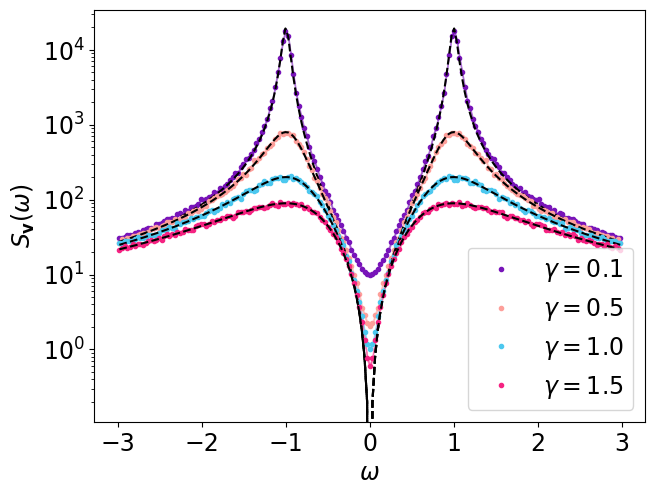

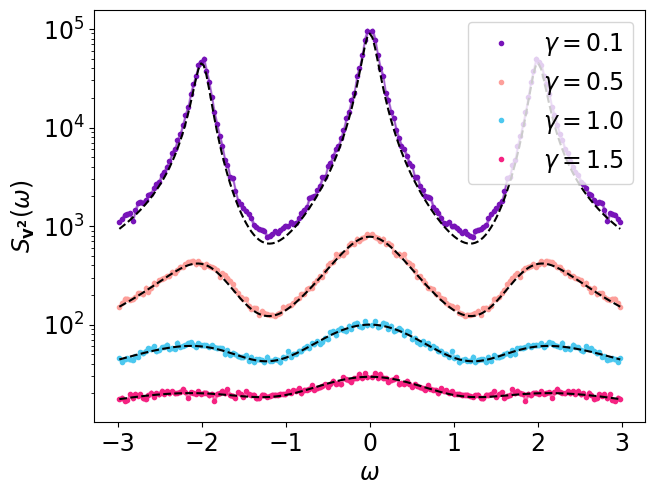

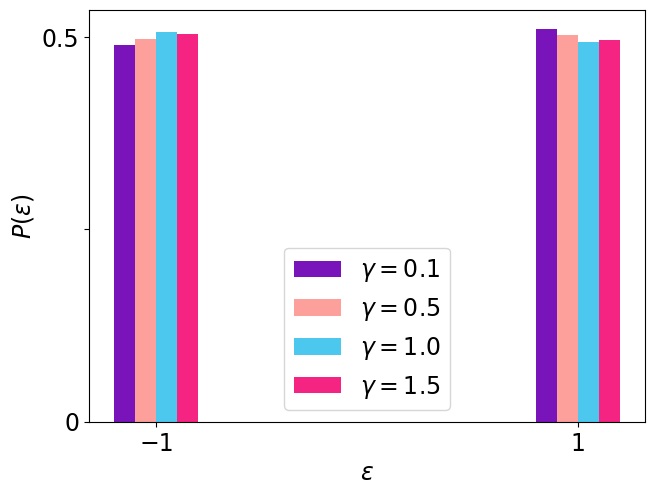

In [12]:
from __future__ import division
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from scipy.optimize import curve_fit

plt.rcParams['text.usetex'] = False 

params = {'text.usetex' : False, 
          'font.size' : 17,
          'font.family' : 'sans-serif', # Recomendado usar una fuente estándar si usetex es False
          }
plt.rcParams.update(params)
color_show = [ '#7814B9', '#FD9F9A', '#4CC8EF', '#F52382' ] 

gamma_show = [ 0.1, 0.5, 1., 1.5 ] # values of the friction coefficient to display


# PLOT THE VELOCTY SPECTRUM 


def spectrum_vel(x, gam, a):

    w = np.sqrt(1. - 0.25 * gam * gam)
    return a * gam * gam * x * x / ( 0.25 * gam * gam + ( x - w ) ** 2 ) / ( 0.25 * gam * gam + ( x + w ) ** 2 ) 

f, ax = plt.subplots()
ax.set_yscale('log')
k = 0
for gam in gamma_show:
    filename = 'OPspectrum_gamma{:.1f}.txt'.format(gam)
    data = np.genfromtxt(filename)
    
    omega = data[:,0]
    spectrum = data[:,1]
    u_spectrum = data[:,2]
    
    spectrum = spectrum[np.absolute(omega) < 3.]
    u_spectrum = u_spectrum[np.absolute(omega) < 3.]
    omega = omega[np.absolute(omega) < 3.]
    
    ax.plot(omega, spectrum, marker = '.', linestyle = '', c = color_show[k], label = r'$\gamma=${0:.1f}'.format(gam))
    ax.fill_between(omega, spectrum - u_spectrum, spectrum + u_spectrum, color = color_show[k], alpha = 0.5) 
    popt, pcov = curve_fit(lambda x, a: spectrum_vel(x, gam, a), omega, spectrum, np.amax(spectrum))
    ax.plot(omega, spectrum_vel(omega, gam, popt[0]), '--k')
    k += 1  
    
ax.set_xlabel(r'$\omega$')
ax.set_ylabel(r'$S_\mathbf{v}(\omega)$')
maj_loc = ticker.LogLocator(numticks = 9)
min_loc = ticker.LogLocator(subs = 'all', numticks = 9)
ax.yaxis.set_major_locator(maj_loc)
ax.yaxis.set_minor_locator(min_loc)
ax.legend()
plt.tight_layout(pad = 0.1, w_pad = 0.0, h_pad = -0.1)
plt.show()


#PLOT THE SPECTRUM OF THE MAGNITUDE OF THE VELOCITY 


def spectrum_vel2(x, gam, a):
    
    w = np.sqrt(1. - 0.25 * gam * gam)
    return a * gam * ( 4. * x ** 4 + x * x * ( gam * gam - 12 * w * w ) + ( gam * gam + 4. * w * w ) ** 2 ) / ( gam * gam + x * x ) / ( gam * gam + ( w + w - x ) ** 2 ) / ( gam * gam + ( w + w + x ) ** 2 )

f, ax = plt.subplots()
ax.set_yscale('log')
k = 0
for gam in gamma_show:
    # Formato de archivo ajustado para leer 'spectrum_norm2_gamma1.0.txt'
    filename = 'OPspectrum_norm2_gamma{:.1f}.txt'.format(gam)
    data = np.genfromtxt(filename)
    
    omega = data[:,0]
    spectrum = data[:,1]
    u_spectrum = data[:,2]
    
    spectrum[np.argmin(np.absolute(omega))] = 0.
    spectrum = spectrum[np.absolute(omega) < 3.]
    u_spectrum = u_spectrum[np.absolute(omega) < 3.]
    omega = omega[np.absolute(omega) < 3.]
    
    ax.plot(omega[omega > 1e-5], spectrum[omega > 1e-5], marker = '.', linestyle = '', c = color_show[k], label = r'$\gamma=${0:.1f}'.format(gam))
    ax.plot(omega[omega < - 1e-5], spectrum[omega < - 1e-5], marker = '.', linestyle = '', c = color_show[k])
    ax.fill_between(omega[omega > 1e-5], spectrum[omega > 1e-5] - u_spectrum[omega > 1e-5], spectrum[omega > 1e-5] + u_spectrum[omega > 1e-5], color = color_show[k], alpha = 0.5)
    ax.fill_between(omega[omega < - 1e-5], spectrum[omega < - 1e-5] - u_spectrum[omega < - 1e-5], spectrum[omega < - 1e-5] + u_spectrum[omega < - 1e-5], color = color_show[k], alpha = 0.5)  
    popt, pcov = curve_fit(lambda x, a: spectrum_vel2(x, gam, a), omega, spectrum, np.amax(spectrum))
    ax.plot(omega, spectrum_vel2(omega, gam, popt[0]), '--k')
    k += 1   
    
ax.set_xlabel(r'$\omega$')
ax.set_ylabel(r'$S_\mathbf{v^2}(\omega)$')
maj_loc = ticker.LogLocator(numticks = 9)
min_loc = ticker.LogLocator(subs = 'all', numticks = 9)
ax.yaxis.set_major_locator(maj_loc)
ax.yaxis.set_minor_locator(min_loc)
ax.legend()
plt.tight_layout(pad = 0.1, w_pad = 0.0, h_pad = -0.1)
plt.show()

# PLOT THE SPIN HISTOGRAM 

x = np.array([-1, 1])
bar_width = 0.1 
f, ax = plt.subplots()
k = 0
for gam in gamma_show:
    # Formato de archivo ajustado para leer 'proba_spin_gamma1.0.txt'
    filename = 'OPproba_spin_gamma{:.1f}.txt'.format(gam)
    data = np.genfromtxt(filename)
    
    proba = data[:,1]
    u_proba = data[:,2]
    
    ax.bar(x + ( k - ( len(gamma_show) - 1. ) * 0.5 ) * bar_width, proba, yerr = u_proba, width = bar_width, color = color_show[k], label = r'$\gamma=${0:.1f}'.format(gam))
    k += 1
    
ax.set_xlabel(r'$\epsilon$')
ax.set_ylabel(r'$P(\epsilon)$')
ax.set_xticks([-1, 1])
ax.set_yticks([0, 0.25, 0.5])
ax.set_yticklabels(['0', '', '0.5'])
ax.legend()
plt.tight_layout(pad = 0.1, w_pad = 0.0, h_pad = -0.1)
plt.show()